In [51]:
import pandas as pd
import importlib
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import preprocessing
from models import vader_sa as vader
from models import afinn_sa as afinn
import utils
importlib.reload(utils)


<module 'utils' from 'c:\\Users\\venug\\Desktop\\antivax_sa\\utils.py'>

# Agenda
<ol>

<li> Create method for basic cleaning, removing retweet tags,etc. </li>
<li> Create method for POS tagging and lemmatization </li>
<li> Run Sentiment analysis on data with basic cleaning using Vader and Afinn. </li>
<li> Train multiple classifiers including Naive Bayes and SVMs on the data. </li>
<li> Write method to tag messages as neutral if average classification probability in the neighbourhood of 0.5, possibly give more weightage to Vader/Affin output </li>
<li> Setup twitter api to get the entire tweets using tweet ids </li>
<li> Setup apis for fb and reddit to be able to access vaccine related posts to enhance model. </li>

In [9]:
preprocessor = preprocessing.Preprocessor()

In [10]:
df_tweets = pd.read_csv(r'./data/vaccine_labeled_tweets.csv',index_col=0)

In [11]:
df_pro = pd.read_csv(r'./data/vaccine_pro.csv')
df_pro.describe()
# df_pro['message'].drop_duplicates()

,tweetid,inreplyuserid,friendscount,userid,favoritecount,followerscount,inreplytweetid,retweetcount,annotation
count,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,10000.0,10000.0
mean,1.383379e+18,4.807362e+16,1303.354900,4.815039e+17,0.0,1.273950e+04,1.766206e+17,0.0,1.0
std,2.890019e+13,2.334947e+17,4606.207082,5.685077e+17,0.0,1.988503e+05,4.616376e+17,0.0,0.0
min,1.383327e+18,-1.000000e+00,0.000000,1.406830e+05,0.0,0.000000e+00,-1.000000e+00,0.0,1.0
25%,1.383355e+18,-1.000000e+00,192.000000,3.300326e+08,0.0,8.600000e+01,-1.000000e+00,0.0,1.0
50%,1.383378e+18,-1.000000e+00,488.000000,2.926940e+09,0.0,3.250000e+02,-1.000000e+00,0.0,1.0
75%,1.383404e+18,-1.000000e+00,1253.250000,1.094894e+18,0.0,1.279250e+03,-1.000000e+00,0.0,1.0
max,1.383427e+18,1.382914e+18,272394.000000,1.383424e+18,0.0,7.832936e+06,1.383427e+18,0.0,1.0


In [12]:
df_anti = pd.read_csv(r'./data/vaccine_anti.csv')
# df_anti['message'].drop_duplicates()

In [13]:
df_anti.columns

Index(['tweetid', 'name', 'inreplyuserid', 'createdat', 'timezone',
       'friendscount', 'accountcreated', 'location', 'userid', 'xcoordinate',
       'message', 'screenname', 'favoritecount', 'followerscount',
       'inreplytweetid', 'retweetcount', 'utcoffset', 'ycoordinate',
       'dataagent', 'place', 'inreplyscreenname', 'category', 'annotation'],
      dtype='object')

In [25]:
df_tweetData = df_pro[['message','annotation']].drop_duplicates()
df_neg = df_anti[['message','annotation']].drop_duplicates()
df_tweetData = df_tweetData.append(df_neg,ignore_index = True)

In [26]:
preprocessor.simple_clean(df_tweetData,'message','message_cleaned')
preprocessor.clean_tweets(df_tweetData,'message_cleaned','message_tokenized')
preprocessor.lemmatize_tweets(df_tweetData,'message_tokenized','message_tokens_lemmatized')

## VADER & afinn based sentiment analysis

In [27]:
df_vader = vader.sentiment_scores(df_tweetData,'message_cleaned')
df_vader.columns = 'vader_' + df_vader.columns
df_tweetData = df_tweetData.join(df_vader)
afinn.sentiment_scores(df_tweetData,'message_cleaned')
df_tweetData

,message,annotation,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score
0,RT @DrEricDing: 📍Huge—Latin America’s main Sin...,1,[RT @DrEricDing:],[DrEricDing],[COVID19],[],📍Huge—Latin America’s main Sinovac (CoronaVac)...,"[📍Huge—Latin, America, ’, main, Sinovac, Coron...","[📍huge—latin, america, ’, main, sinovac, coron...","{'neg': 0.057, 'neu': 0.781, 'pos': 0.161, 'co...",0.057,0.781,0.161,0.4588,0.0
1,@virsanghvi The competencies and qualification...,1,[],[virsanghvi],[],[],The competencies and qualifications of ministe...,"[competencies, qualifications, ministers, well...","[competency, qualification, minister, well, kn...","{'neg': 0.0, 'neu': 0.832, 'pos': 0.168, 'comp...",0.000,0.832,0.168,0.7845,8.0
2,First vaccination = done. https://t.co/MG0mFnrG9q,1,[],[],[],[https://t.co/MG0mFnrG9q],First vaccination = done.,"[First, vaccination, done]","[first, vaccination, do]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0
3,@SreeIyer1 @Swamy39 Now let$q$s focus on threa...,1,[],"[SreeIyer1, Swamy39]",[],[],Now let$q$s focus on threat of Covaxin also.Pe...,"[let, q, focus, threat, Covaxin, also.People, ...","[let, q, focus, threat, covaxin, also.people, ...","{'neg': 0.117, 'neu': 0.724, 'pos': 0.159, 'co...",0.117,0.724,0.159,0.0516,-1.0
4,@Cpgaf1 @SenSchumer I agree with pausing the J...,1,[],"[Cpgaf1, SenSchumer]",[],[],"I agree with pausing the J J vaccine, but I al...","[agree, pausing, J, J, vaccine, also, think, n...","[agree, pause, j, j, vaccine, also, think, nee...","{'neg': 0.056, 'neu': 0.828, 'pos': 0.116, 'co...",0.056,0.828,0.116,0.3291,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,"Ayrshire woman demands answers after son, 20, ...",-1,[],[],[],[https://t.co/mMSCBKnVk0],"Ayrshire woman demands answers after son, 20, ...","[Ayrshire, woman, demands, answers, son, 20, d...","[ayrshire, woman, demand, answer, son, 20, dy,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,-1.0
8310,The failure to secure sufficient vaccine suppl...,-1,[],[],[],[https://t.co/IaGwcdTTfQ],The failure to secure sufficient vaccine suppl...,"[failure, secure, sufficient, vaccine, supply,...","[failure, secure, sufficient, vaccine, supply,...","{'neg': 0.277, 'neu': 0.643, 'pos': 0.08, 'com...",0.277,0.643,0.080,-0.8718,-9.0
8311,@libtard_cuck @ProlongingCovid @snowride70 The...,-1,[],"[libtard_cuck, ProlongingCovid, snowride70]",[],[],The conspiracy theory that includes economic c...,"[conspiracy, theory, includes, economic, colla...","[conspiracy, theory, include, economic, collap...","{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",0.375,0.625,0.000,-0.8625,-6.0
8312,@WFIUNews WEDNESDAY INDIANA #COVID19 VACCINE N...,-1,[],[WFIUNews],[COVID19],[],WEDNESDAY INDIANA #COVID19 VACCINE NUMBERS: - ...,"[WEDNESDAY, INDIANA, COVID19, VACCINE, NUMBERS...","[wednesday, indiana, covid19, vaccine, numbers...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0


Word Cloud Saved Successfully


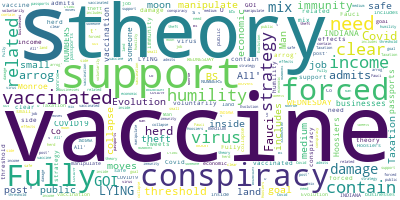

In [52]:
utils.create_wordcloud(df_tweetData.loc[df_tweetData['annotation'] == -1,'message_cleaned'].values)